In [6]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette=[sns.color_palette('muted')[i] for i in [0,2]], 
        color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

# import keras as ke
# import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

create_gif = False

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"tensorflow: {tf.__version__}")


sklearn: 0.24.2
pandas: 1.3.4
tensorflow: 2.9.0


# Training a basic classifier that can predict whether or not a person's income is larger than 50K dollar a year

First parse the data into three datasets: features, targets and sensitive attributes. The set of features  contains the input attributes that the model uses for making the predictions, with attributes like age, education level and occupation. The targets  contain the binary class labels that the model needs to predict.

label y for prediction income greater or less than 50k, the set of sensitive attributes  contains the attributes for which we want the prediction to fair. These are z race(white, black) and z gender(male, female).

In [49]:
def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'marital.status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital.gain', 'capital.loss', 'hours.per.week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['sex'].isin(['Male', 'Female'])])

    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'sex'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))
    
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z

In [50]:
X, y, Z = load_ICU_data(r"C:\Users\reemn\Downloads\fairness-in-ml-master\fairness-in-ml-master\data\adult.data")

features X: 32561 samples, 99 attributes
targets y: 32561 samples
sensitives Z: 32561 samples, 1 attributes


Split the data into train and test sets, where the split is 50/50, and scale the features  using standard scaling

In [51]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.5, 
                                                                     stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler)

Now, let's train our basic income level predictor. We use Keras to fit a simple three-layer network with ReLU activations and dropout on the training data. The output of the network is a single node with sigmoid activation, so it predicts "the probability that this person's income is larger than 50K".

In [52]:
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# initialise NeuralNet Classifier
clf = nn_classifier(n_features=X_train.shape[1])

# train on train set
history = clf.fit(X_train.values, y_train.values, epochs=20, verbose=0)

Finally, we use this classifier to make income level predictions on the test data. We determine the model performance by computing the Area Under the Curve and the accuracy score using test set predictions.

In [53]:
# predict on test set
y_pred = pd.Series(clf.predict(X_test.values).ravel(), index=y_test.index)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Accuracy: {100*accuracy_score(y_test, (y_pred>0.5)):.1f}%")

509/509 [==============================] - 0s 718us/step
ROC AUC: 0.91
Accuracy: 85.2%


We start the investigation into the fairness of our classifier by analysing the predictions it made on the test set. The plots in the figure below show the distributions of the predicted (P(INCOME>50K)) given the sensitive attributes.

In [73]:
# HIDE
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None):
    fig, axes = plt.subplots(1,2, figsize=(10, 4), sharey=True)
    legend={'sex': ['female','male']}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0,1]:
            ax = sns.kdeplot(data=y[Z[attr] == attr_val],
                             label='{}'.format(legend[attr][attr_val]), 
                             ax=axes[idx], fill=True)
        ax.set_xlim(0,1)
        ax.set_ylim(0,7)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx == 0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(attr))
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     [f"- {attr}: {p_rules[attr]:.0f}%-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight',  dpi = 300)
    return fig

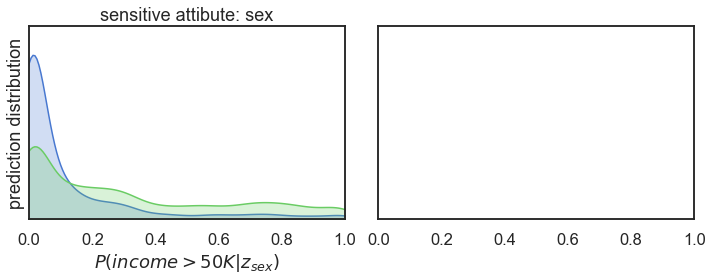

In [74]:
fig = plot_distributions(y_pred, Z_test, fname=r'C:\Users\reemn\Downloads\fairness-in-ml-master\fairness-in-ml-master\images/biased_training.png')

The figure shows for both race (=left plot) and sex (=right plot) the blue prediction distributions have a large peak at the low end of the probability range. This means that when a person is black and/or female  there is a much higher probability of the classifier predicting an income below 50K compared to when someone is black and/or male .

So, the results of the qualitative analysis are quite clear: the predictions are definitely not fair when considered in the context of race and sex. When it comes to assigning the high-income levels, our model favours the usual suspects: white males.

In order to get a 'quantitative' measure of how fair our classifier is, we take inspiration from the U.S. Equal Employment Opportunity Commission (EEOC). They use the so-called 80% rule to quantify the disparate impact on a group of people of a protected characteristic. Zafar et al. show in their paper "Fairness Constraints: Mechanisms for Fair Classification" how a more generic version of this rule, called the p%-rule, can be used to quantify fairness of a classifier. This rule is defined as follows:

The rule states that the ratio between the probability of a positive outcome given the sensitive attribute being true and the same probability given the sensitive attribute being false is no less than p:100. So, when a classifier is completely fair it will satisfy a 100%-rule. In contrast, when it is completely unfair it satisfies a %0-rule.

In determining the fairness our or classifier we will follow the EEOC and say that a model is fair when it satisfies at least an 80%-rule. So, let's compute the p%-rules for the classifier and put a number on its fairness. Note that we will threshold our classifier at 0.5 to make its prediction it binary.

In [29]:
# HIDE
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [30]:
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['race']):.0f}%-rule")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['sex']):.0f}%-rule")

The classifier satisfies the following %p-rules:
	given attribute race; 47%-rule
	given attribute sex;  36%-rule


In [11]:
#pip install keras-rl2

Note: you may need to restart the kernel to use updated packages.


We find that for both sensitive attributes the classifier satisfies a p%-rule that is significantly lower than 80%. This supports our earlier conclusion that the trained classifier is unfair in making its predictions.

# Fair income predictions
Finally, we are ready to adverserial train a fair classifier. We kick-off by initializing our newly upgraded classifier and pre-train both the classifier and adverserial networks:

In [42]:
# HIDE

class FairClassifier(object):
    
    def __init__(self, n_features, n_sensitive, lambdas):
        self.lambdas = lambdas
        
        clf_inputs = Input(shape=(n_features,))
        adv_inputs = Input(shape=(1,))
        
        clf_net = self._create_clf_net(clf_inputs)
        adv_net = self._create_adv_net(adv_inputs, n_sensitive)
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)
        self._clf = self._compile_clf(clf_net)
        self._clf_w_adv = self._compile_clf_w_adv(clf_inputs, clf_net, adv_net)
        self._adv = self._compile_adv(clf_inputs, clf_net, adv_net, n_sensitive)
        self._val_metrics = None
        self._fairness_metrics = None
        
        self.predict = self._clf.predict
        
    def _make_trainable(self, net):
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable
        
    def _create_clf_net(self, inputs):
        dense1 = Dense(32, activation='relu')(inputs)
        dropout1 = Dropout(0.2)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        dense3 = Dense(32, activation='relu')(dropout2)
        dropout3 = Dropout(0.2)(dense3)
        outputs = Dense(1, activation='sigmoid', name='y')(dropout3)
        return Model(inputs=[inputs], outputs=[outputs])
        
    def _create_adv_net(self, inputs, n_sensitive):
        dense1 = Dense(32, activation='relu')(inputs)
        dense2 = Dense(32, activation='relu')(dense1)
        dense3 = Dense(32, activation='relu')(dense2)
        outputs = [Dense(1, activation='sigmoid')(dense3) for _ in range(n_sensitive)]
        return Model(inputs=[inputs], outputs=outputs)

    def _compile_clf(self, clf_net):
        clf = clf_net
        self._trainable_clf_net(True)
        clf.compile(loss='binary_crossentropy', optimizer='adam')
        return clf
        
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):
        clf_w_adv = Model(inputs=[inputs], outputs=[clf_net(inputs)]+adv_net(clf_net(inputs)))
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        loss_weights = [1.]+[-lambda_param for lambda_param in self.lambdas]
        clf_w_adv.compile(loss=['binary_crossentropy']*(len(loss_weights)), 
                          loss_weights=loss_weights,
                          optimizer='adam')
        return clf_w_adv

    def _compile_adv(self, inputs, clf_net, adv_net, n_sensitive):
        adv = Model(inputs=[inputs], outputs=adv_net(clf_net(inputs)))
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        adv.compile(loss=['binary_crossentropy']*n_sensitive, loss_weights=self.lambdas, 
                    optimizer='adam')
        return adv

    def _compute_class_weights(self, data_set, classes=[0, 1]):
        class_weights = []
        if len(data_set.shape) == 1:
            balanced_weights = compute_class_weight('balanced', classes=classes, y=data_set)
            class_weights.append(dict(zip(classes, balanced_weights)))
        else:
            n_attr =  data_set.shape[1]
            for attr_idx in range(n_attr):
                balanced_weights = compute_class_weight('balanced', classes=classes,
                                                        y=np.array(data_set)[:,attr_idx])
                class_weights.append(dict(zip(classes, balanced_weights)))
        return class_weights
    
    def _compute_target_class_weights(self, y, classes=[0, 1]):
        balanced_weights =  compute_class_weight('balanced', classes=classes, y=y)
        class_weights = {'y': dict(zip(classes, balanced_weights))}
        return class_weights
        
    def pretrain(self, x, y, z, epochs=10, verbose=0):
        self._trainable_clf_net(True)
        self._clf.fit(x.values, y.values, epochs=epochs, verbose=verbose)
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        class_weight_adv = self._compute_class_weights(z)
        self._adv.fit(x.values, np.hsplit(z.values, z.shape[1]), class_weight=class_weight_adv, 
                      epochs=epochs, verbose=verbose)
        
    def fit(self, x, y, z, validation_data=None, T_iter=250, batch_size=128,
            save_figs=False, verbose=0):
        n_sensitive = z.shape[1]
        if validation_data is not None:
            x_val, y_val, z_val = validation_data
        
        class_weight_clf = [{0:1., 1:1.}]
        class_weight_adv = self._compute_class_weights(z)
        class_weight_clf_w_adv = class_weight_clf+class_weight_adv
        self._val_metrics = pd.DataFrame()
        self._fairness_metrics = pd.DataFrame()  
        for idx in range(T_iter):
            if validation_data is not None:
                y_pred = pd.Series(self._clf.predict(x_val.values).ravel(), index=y_val.index)
                self._val_metrics.loc[idx, 'ROC AUC'] = roc_auc_score(y_val, y_pred)
                self._val_metrics.loc[idx, 'Accuracy'] = (accuracy_score(y_val, (y_pred>0.5))*100)
                for sensitive_attr in z_val.columns:
                    self._fairness_metrics.loc[idx, sensitive_attr] = p_rule(y_pred,
                                                                             z_val[sensitive_attr])
                display.clear_output(wait=True)
                plot_distributions(y_pred, z_val, idx+1, self._val_metrics.loc[idx],
                                   self._fairness_metrics.loc[idx], 
                                   fname=f'output/{idx+1:08d}.png' if save_figs else None)
                plt.show(plt.gcf())
            
            
            # train adverserial
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            self._adv.fit(x.values, np.hsplit(z.values, z.shape[1]), batch_size=batch_size, 
                          class_weight=class_weight_adv, epochs=1, verbose=verbose)
            
            # train classifier 
            # !Changed this into several epochs on whole dataset instead of single random minibatch!
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            indices = np.random.permutation(len(x))[:batch_size]
            self._clf_w_adv.fit(x.values, [y.values]+np.hsplit(z.values, z.shape[1]), batch_size=len(x), 
                                class_weight=class_weight_clf_w_adv, epochs=5, verbose=verbose)

In [58]:
# initialise FairClassifier
clf = FairClassifier(n_features=X_train.shape[1], n_sensitive=Z_train.shape[1],
                     lambdas=[5., 5.])

# pre-train both adverserial and classifier networks
clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5)

ValueError: TypeError: Keras symbolic inputs/outputs do not implement `__len__`. You may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model. This error will also get raised if you try asserting a symbolic input/output directly.
Traceback (most recent call last):

  File "C:\Users\reemn\anaconda3\lib\site-packages\keras\engine\keras_tensor.py", line 221, in __len__
    raise TypeError('Keras symbolic inputs/outputs do not '

TypeError: Keras symbolic inputs/outputs do not implement `__len__`. You may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model. This error will also get raised if you try asserting a symbolic input/output directly.



The supplied  values, that tune fairness versus accuracy, are set to  and . We heuristically found that these settings result in a balanced increase of the p%-rule values during training.

Now that both networks have been pre-trained, the adversarial training can start. We will simultaneously train both networks for 25 iterations while tracking the performance of the classifier on the test data:

In [33]:
if create_gif:
    !rm output/*.png

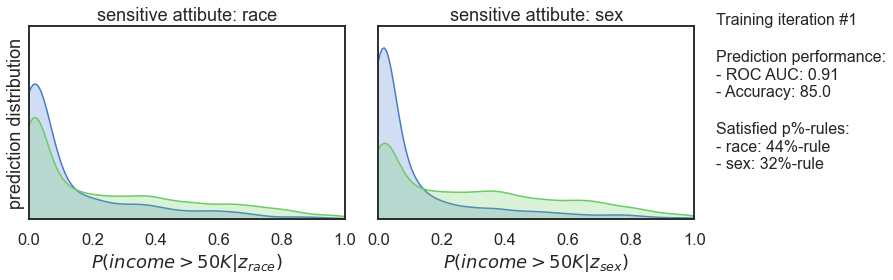

AttributeError: 'list' object has no attribute 'keys'

In [34]:
# adverserial train on train set and validate on test set
clf.fit(X_train, y_train, Z_train, 
        validation_data=(X_test, y_test, Z_test),
        T_iter=25, save_figs=create_gif, verbose=0)

In [20]:
# HIDE
if create_gif:
    !convert -loop 0 -delay 25 output/*.png -delay 500 output/00000025.png -layers OptimizePlus images/training.gif

The plots above show how the prediction distributions, the satisfied p%-rules and the prediction performance of our classifier evolve during adversarial training. At iteration #1, when training is just starting out, the predictions are very much the same as observed for the previously trained classifier: both high in bias and in prediction performance. As the training progresses, we see that the predictions are gradually become more and more fair while prediction performance is slightly declining. Finally, after 165 iterations of training, we see that the classifier satisfies the 80%-rule for both sensitive attributes while achieving a ROC AUC 0.85 and an accuracy of 82%.

So, it seems that the training procedure works quite well. After sacrificing only 7% of prediction performance, we end up with a classifier that makes fair predictions when it comes to race and sex. A pretty decent result!